In [1]:
CPU_CORES # -> system var that contains the numbr of available cores

4

In [2]:
nprocs() # -> the currently available, to julia, number of cores

1

In [3]:
addprocs(CPU_CORES - 1) # -> Make all cores available to Julia

3-element Array{Any,1}:
 2
 3
 4

In [4]:
r = remotecall(2, rand, 2, 2) # -> we can make a call, on processor 2, to the function rand with arguments 2 and 2.

RemoteRef(2,1,9)

In [5]:
fetch(r) # -> this function allows us to fetch the data that was created on another processor and 
#bring it into the scope of the master processor

2x2 Array{Float64,2}:
 0.195311  0.699111
 0.763146  0.517326

In [11]:
# can you create and fetch a matrix of zeros of size 14 by 14 on processor 3?






In [12]:
s = @spawnat 2 rand(2,2) # -> a much nicer syntax that makes use of a julia macro
fetch(s)

2x2 Array{Float64,2}:
 0.984253  0.618944
 0.481985  0.472362

In [13]:
k = @fetchfrom 2 rand(2,2)# -> spawn on processor 2 and then fetch on completion
k

2x2 Array{Float64,2}:
 0.0885738  0.373951
 0.147095   0.279836

In [14]:
myid() # -> function for determining the process ID

1

In [15]:
@fetchfrom 3 myid() # -> this makes the macro behaviour easier to see. The function was called on 
#processor 3 and so returned ID 3

3

In [16]:
r = @spawn myid() # -> @spawn chooses an available processor to run the function on this will change on each run
fetch(r)

2

In order to see the parrallel abilities of Julia we shall look at an embarrassingly parrallel problem - the calculation of $\pi$ via Monte Carlo sampling. We will randomly draw x and y samples in the range [-1,1] and calculate the distance from the origin. If the distance is less than one then the sample lies within the circle if not then it lies outside. By calculating the ratio of interior to exterior points we can estimate $\pi$ - the more samples we take the better our approximation. The fact that each sample is independent of all others makes this an excellent candidate for parallelism.   

In [6]:
function compute_pi(N::Int)
    """
    Compute pi with a Monte Carlo simulation of N darts thrown in [-1,1]^2
    Returns estimate of pi
    """
    n_landed_in_circle = 0  # counts number of points that have radial coordinate < 1, i.e. in circle
    for i = 1:N
        x = rand() * 2 - 1  # uniformly distributed number on x-axis
        y = rand() * 2 - 1  # uniformly distributed number on y-axis
 
        r2 = x*x + y*y  # radius squared, in radial coordinates
        if r2 < 1.0
            n_landed_in_circle += 1
        end
    end
 
    return n_landed_in_circle / N * 4.0    
end

compute_pi (generic function with 1 method)

In [12]:
pi = compute_pi(int(10e7)) # -> we can compute an approximation for pi for N = 10e7

3.14151268

In [15]:
pis = map(compute_pi,int(logspace(1,7,100))) # -> we can use the map function to calculate a range of approximations for
# different values of N

100-element Array{Float64,1}:
 3.6    
 2.90909
 2.46154
 2.93333
 3.05882
 3.4    
 2.78261
 2.37037
 2.96774
 2.74286
 3.6    
 3.13043
 3.09434
 ⋮      
 3.14048
 3.14229
 3.14186
 3.14015
 3.14086
 3.14058
 3.14252
 3.14159
 3.14152
 3.14218
 3.14159
 3.14254

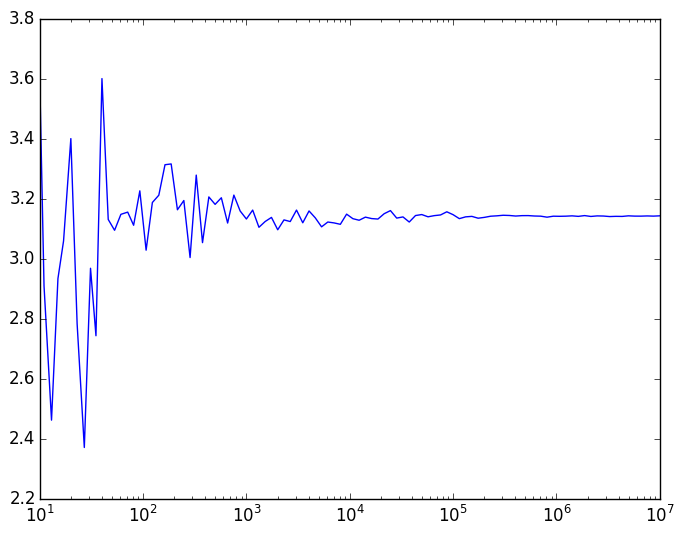

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x10f428a90>

In [18]:
using PyPlot # -> import library which allows us to use matplotlibs plotting functions
semilogx(int(logspace(1,7,100)),pis) # -> logplot of pi approximations

In [19]:
pis = pmap(compute_pi,int(logspace(1,8,100))) # -> pmap function applies the function to each of the arguments making
# use of processors as they come available

exception on 4: exception on exception on 2: 3: ERROR: function compute_pi not defined on process 4
 in error at error.jl:21
 in anonymous at serialize.jl:397
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
ERROR: function compute_pi not defined on process 2
 in error at error.jl:21
 in anonymous at serialize.jl:397
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
ERROR: function compute_pi not defined on process 3
 in error at error.jl:21
 in anonymous at serialize.jl:397
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855


3-element Array{Any,1}:
 ErrorException("function compute_pi not defined on process 2")
 ErrorException("function compute_pi not defined on process 3")
 ErrorException("function compute_pi not defined on process 4")

Only the master process knows about this function definition and so when pmap asks other proceeses to use this function they have no idea what to do! We must use the julia @everywhere macro to let all processes know about a function. 

In [20]:
@everywhere function compute_pi(N::Int)
    """
    Compute pi with a Monte Carlo simulation of N darts thrown in [-1,1]^2
    Returns estimate of pi
    """
    n_landed_in_circle = 0  # counts number of points that have radial coordinate < 1, i.e. in circle
    for i = 1:N
        x = rand() * 2 - 1  # uniformly distributed number on x-axis
        y = rand() * 2 - 1  # uniformly distributed number on y-axis
 
        r2 = x*x + y*y  # radius squared, in radial coordinates
        if r2 < 1.0
            n_landed_in_circle += 1
        end
    end
 
    return n_landed_in_circle / N * 4.0    
end

In [21]:
pis = pmap(compute_pi,int(logspace(1,8,100)))

100-element Array{Any,1}:
 4.0    
 2.66667
 3.14286
 3.25   
 2.73684
 2.6087 
 2.51852
 3.22581
 2.91892
 2.51163
 2.98039
 2.93333
 3.49296
 ⋮      
 3.14252
 3.14111
 3.14164
 3.14141
 3.14135
 3.14147
 3.14203
 3.14137
 3.14153
 3.14173
 3.14159
 3.14147

In [ ]:
# Can you write some code that will allow you to time the average execution of the normal map function and the 
# pmap function? 
#
# HINT: tic() and tock()















In [1]:
# we can perform reduction loops in parrallel using @parallel
sum = @parallel (+) for i = 1:1000000
    sin(i)
end

-0.11710952409816672

In [26]:
@everywhere function par_compute_pi(N,ncores)
    each  = int(floor(N/ncores))
    left = N%ncores

    sum_of_pis = @parallel (+) for i=1:ncores
        if i <= left
            compute_pi(each+1)
        else
            compute_pi(each)
        end
    end

    return sum_of_pis / ncores
end

In [45]:
time = 0 
for i = 1:10
    tic() 
    pi = par_compute_pi(int(10e7),1)
    time+=toc()
end

println("avg time = ",time/10)

elapsed time: 0.135106279 seconds
elapsed time: 0.122012 seconds
elapsed time: 0.122494676 seconds
elapsed time: 0.124619668 seconds
elapsed time: 0.121832826 seconds
elapsed time: 0.124469028 seconds
elapsed time: 0.130674546 seconds
elapsed time: 0.12665145 seconds
elapsed time: 0.129598744 seconds
elapsed time: 0.120853728 seconds
avg time = 0.1258312945
